In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [421]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA

### Missing values

In [262]:
feature_with_na = [i for i in df.columns if df[i].isnull().sum()>1]

for i in feature_with_na:
    print('{}: {} % missing values'.format(i, round(df[i].isnull().mean(),3)))

LotFrontage: 0.177 % missing values
Alley: 0.938 % missing values
MasVnrType: 0.005 % missing values
MasVnrArea: 0.005 % missing values
BsmtQual: 0.025 % missing values
BsmtCond: 0.025 % missing values
BsmtExposure: 0.026 % missing values
BsmtFinType1: 0.025 % missing values
BsmtFinType2: 0.026 % missing values
FireplaceQu: 0.473 % missing values
GarageType: 0.055 % missing values
GarageYrBlt: 0.055 % missing values
GarageFinish: 0.055 % missing values
GarageQual: 0.055 % missing values
GarageCond: 0.055 % missing values
PoolQC: 0.995 % missing values
Fence: 0.808 % missing values
MiscFeature: 0.963 % missing values


> Since there are many missing values, we need to find the relationship between missing value and sales price

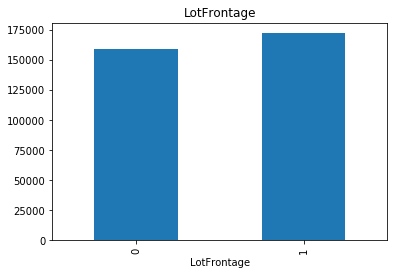

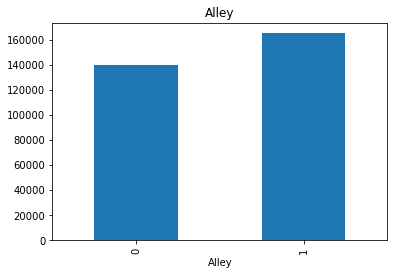

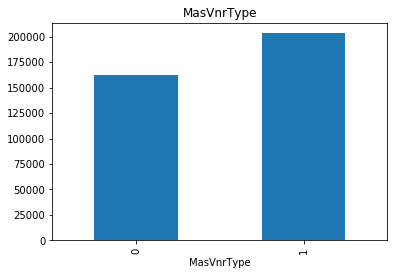

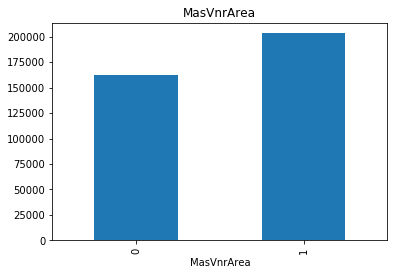

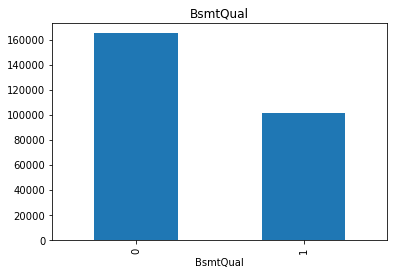

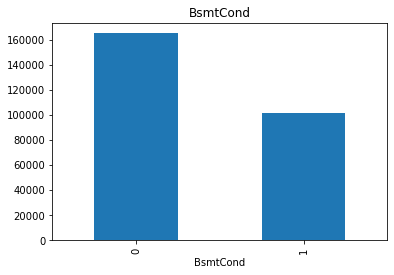

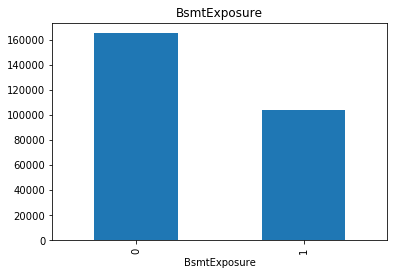

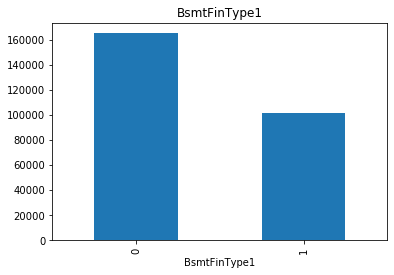

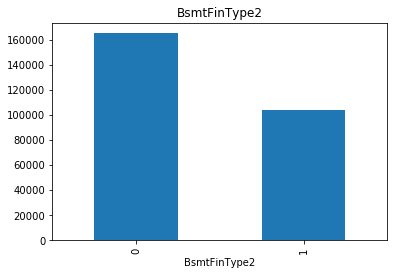

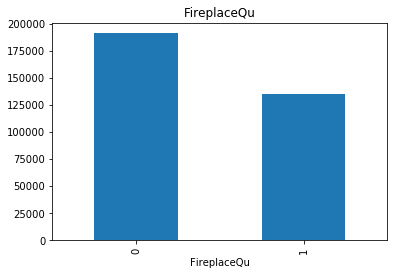

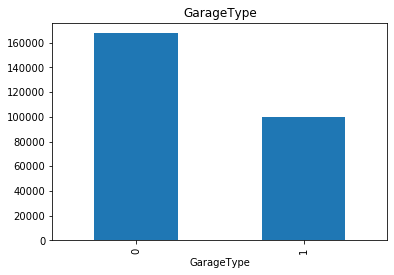

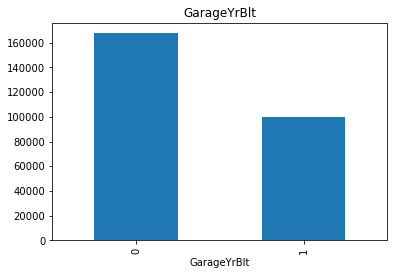

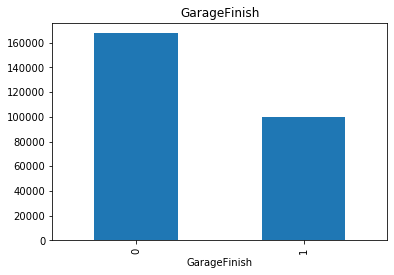

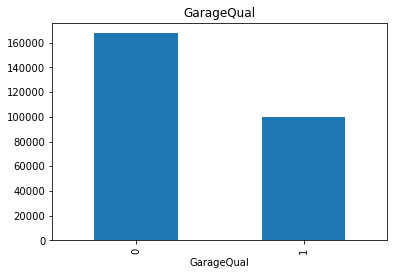

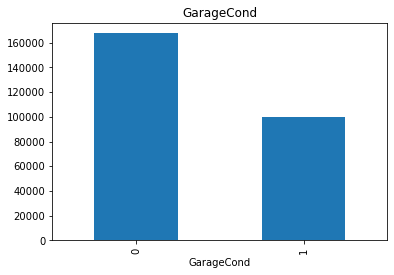

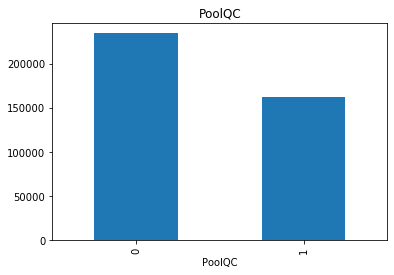

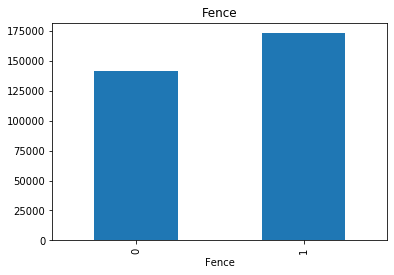

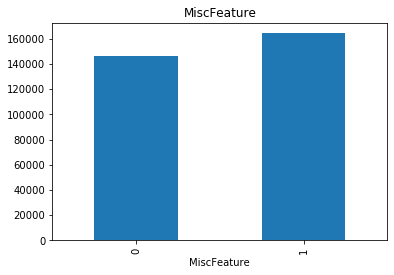

In [263]:
for i in feature_with_na:
    df1 = df.copy()
    df1[i] = np.where(df1[i].isnull(),1,0)
    
    df1.groupby(i)['SalePrice'].median().plot.bar()
    plt.title(i)
    plt.show()

> Here the relationship between the missing values and the dependent variable is clearly visible, so we need to replace
these nan values with something meaningful which we will do in the Feature engineering section

### Temporal Variables (Date Time Variables)

> From the Dataset we have 4 year variable, we need to extract information from the datetime variable like no_of years or no of days

In [264]:
numerical_feature = [i for i in df.columns if df[i].dtypes != 'O']
numerical_feature

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [265]:
year_feature = [ i for i in  numerical_feature if 'Yr' in  i or 'Year' in i]

In [266]:
for i in year_feature:
    print(i, df[i].unique())
    print('-'*50)

YearBuilt [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
--------------------------------------------------
YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]
----------------------------------------------

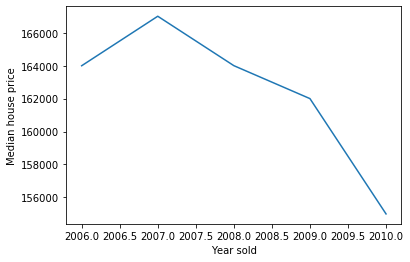

In [267]:
# Lets Analyse the temporal datetime variable

df.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year sold')
plt.ylabel('Median house price')
plt.show()

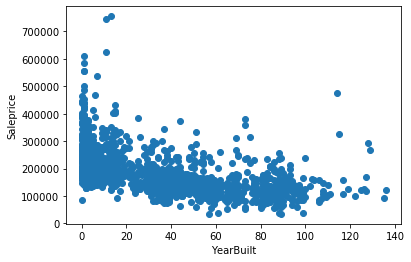

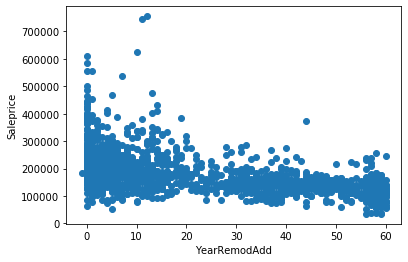

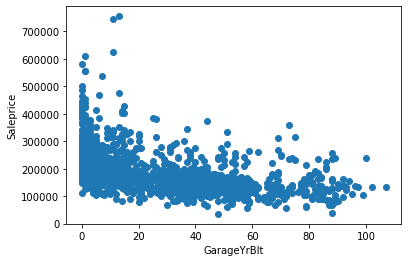

In [268]:
# Here we will compare the difference betweeen all the year feature with salesprice

for i in year_feature:
    if i != 'YrSold':
        df1 = df.copy()
        df1[i] = df1['YrSold'] - df1[i]
        
        plt.scatter(df1[i], df1['SalePrice'])
        plt.xlabel(i)
        plt.ylabel('Saleprice')
        plt.show()

> Here the plot shows that, if the house is old , then the price is low compared to new house

# Discrete Variables

In [269]:
Discrete_feature = [i for i in numerical_feature if len(df[i].unique())< 25 and i not in year_feature+['Id']]
Discrete_feature

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold']

In [270]:
df[Discrete_feature].head()

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold
0,60,7,5,0,1,0,2,1,3,1,8,0,2,0,0,0,2
1,20,6,8,0,0,1,2,0,3,1,6,1,2,0,0,0,5
2,60,7,5,0,1,0,2,1,3,1,6,1,2,0,0,0,9
3,70,7,5,0,1,0,1,0,3,1,7,1,3,0,0,0,2
4,60,8,5,0,1,0,2,1,4,1,9,1,3,0,0,0,12


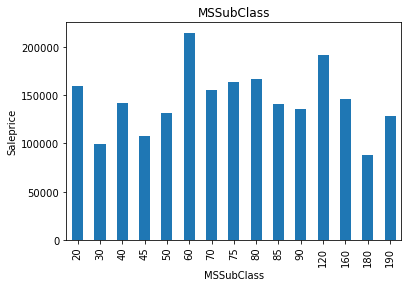

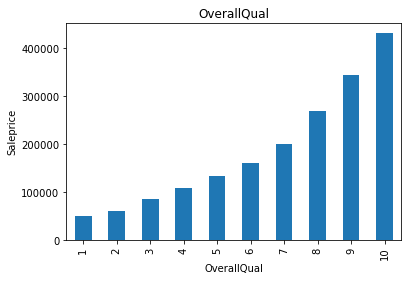

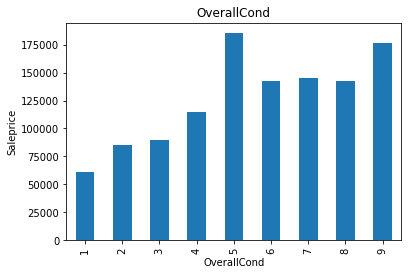

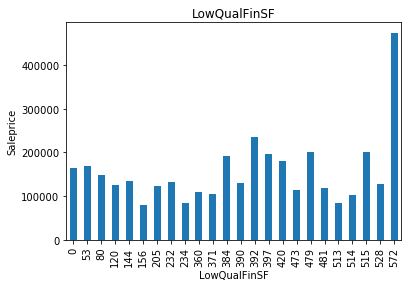

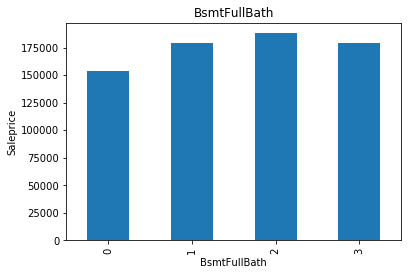

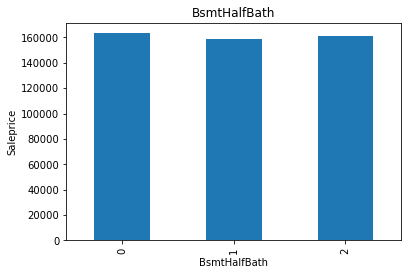

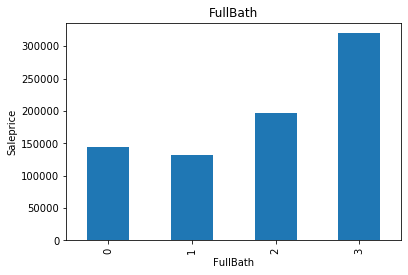

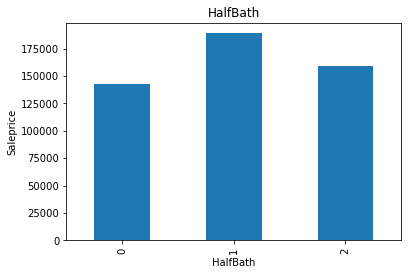

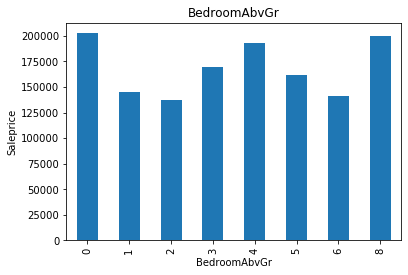

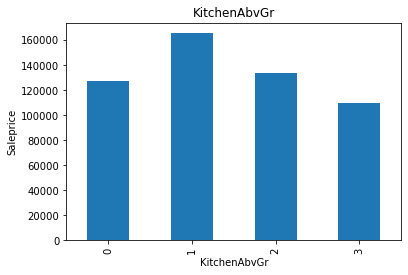

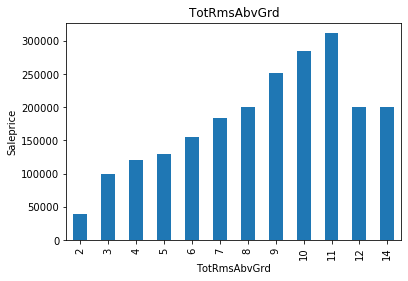

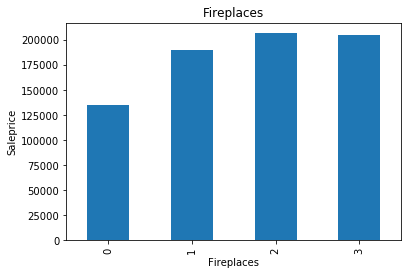

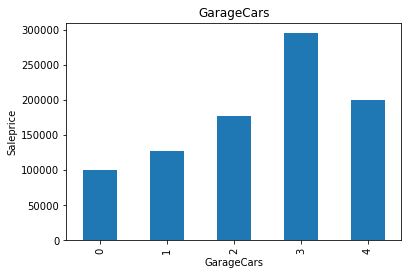

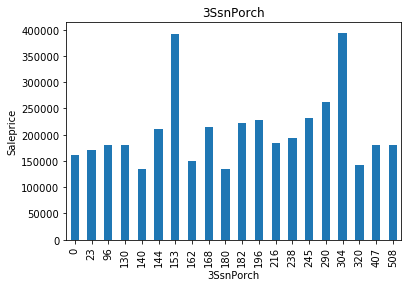

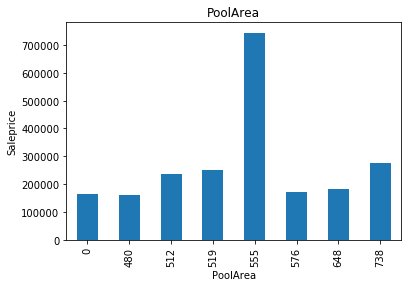

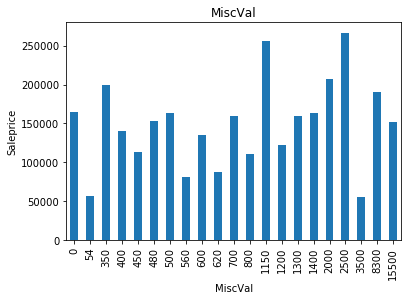

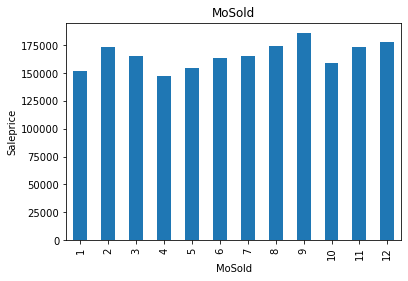

In [271]:
for i in Discrete_feature:
    df.groupby(i)['SalePrice'].median().plot.bar()
    plt.xlabel(i)
    plt.ylabel('Saleprice')
    plt.title(i)
    plt.show()

> There is a relationship with the target variable

# Continuous variables

In [272]:
cont_feature = [i for i in numerical_feature if i not in Discrete_feature+ year_feature + ['Id']]
cont_feature

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SalePrice']

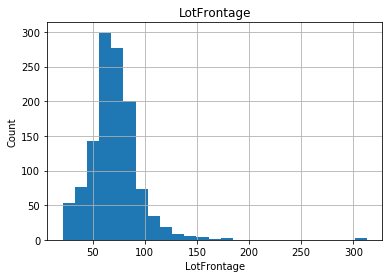

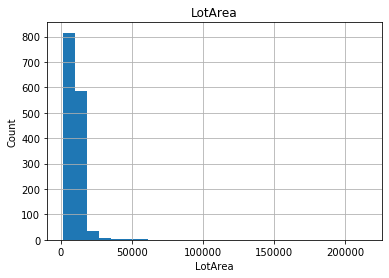

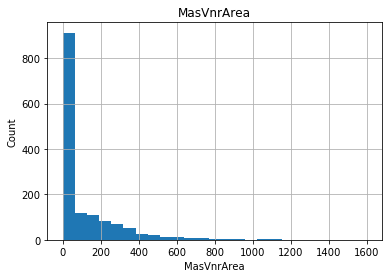

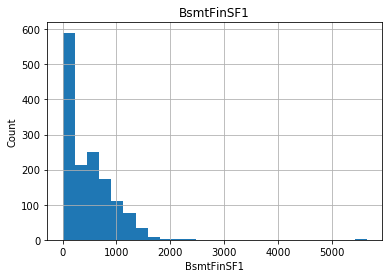

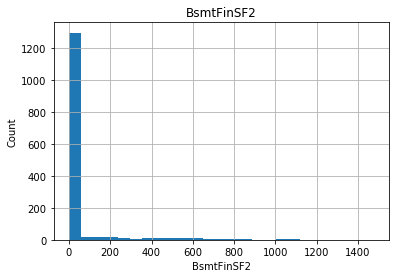

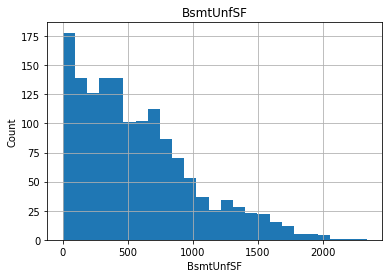

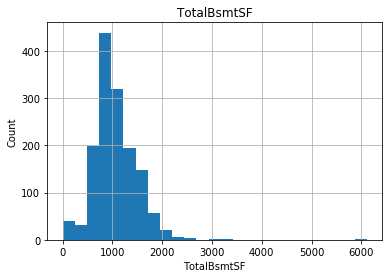

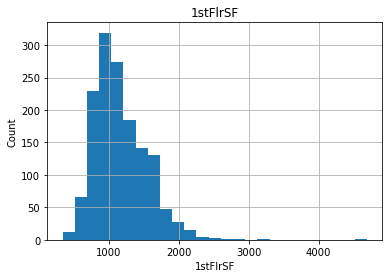

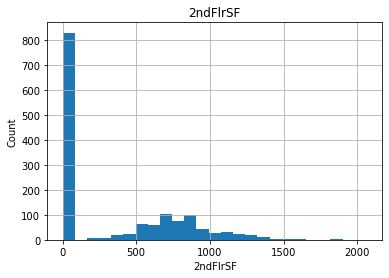

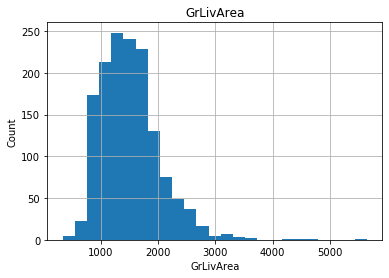

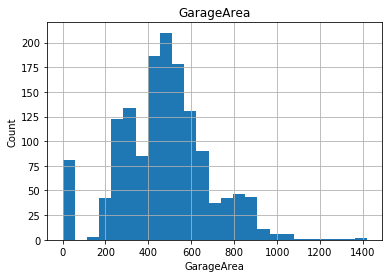

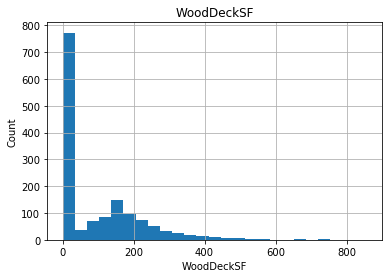

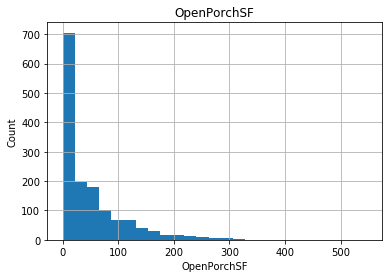

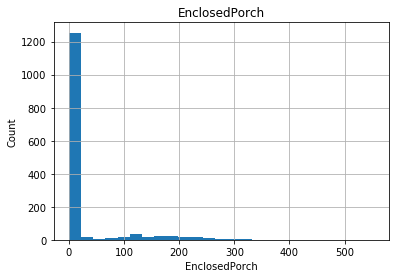

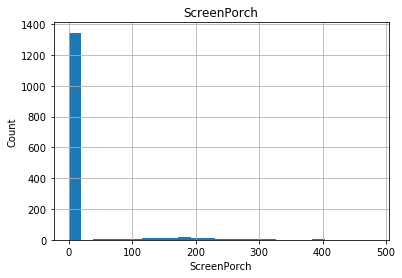

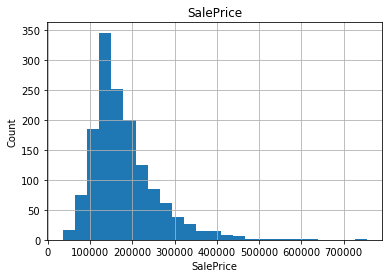

In [273]:
for i in cont_feature:
    df[i].hist(bins = 25)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title(i)
    plt.show()

> Here some of the features has qaussian distribution oters are skewed, so for linear regression, the data should be normally distributed, if not we need to transform to log 

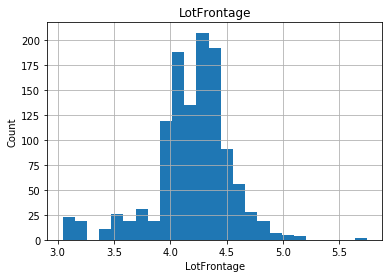

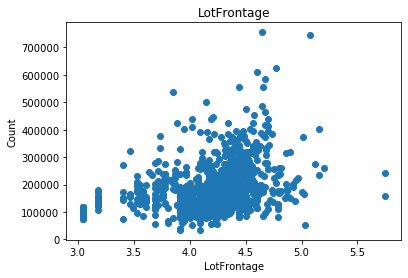

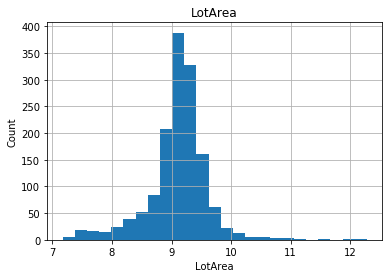

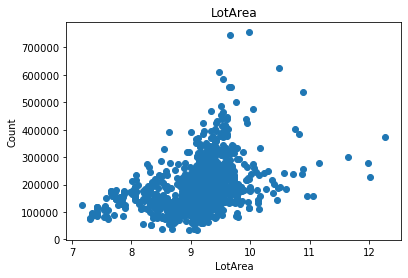

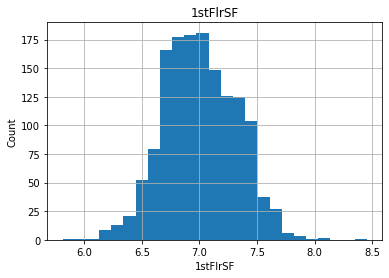

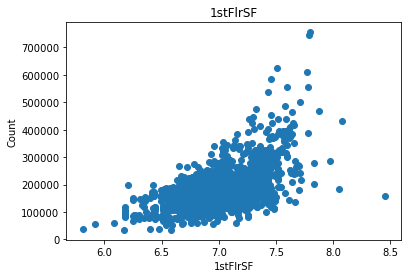

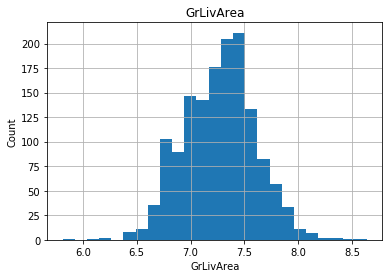

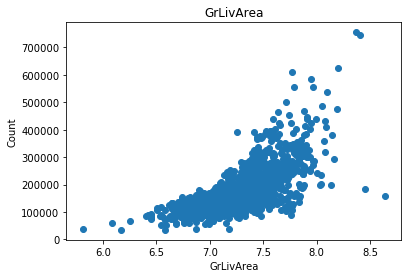

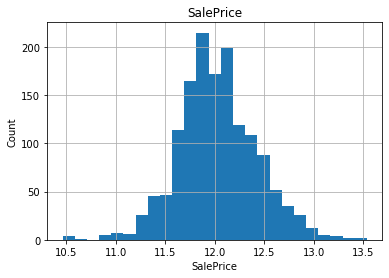

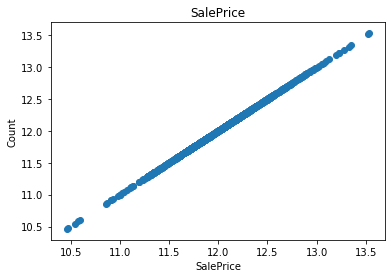

In [274]:
for i in cont_feature:
    df1 = df.copy()
    if 0 in df[i].unique():
        pass
    else:
        df1[i] = np.log(df[i])
        df1[i].hist(bins = 25)
        plt.xlabel(i)
        plt.ylabel('Count')
        plt.title(i)
        plt.show()
        plt.scatter(df1[i], df1['SalePrice'])
        plt.xlabel(i)
        plt.ylabel('Count')
        plt.title(i)
        plt.show()

# Outliers

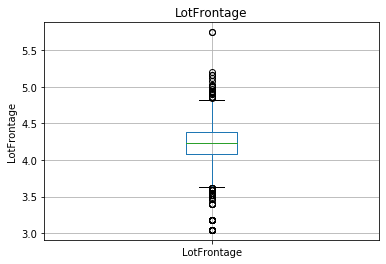

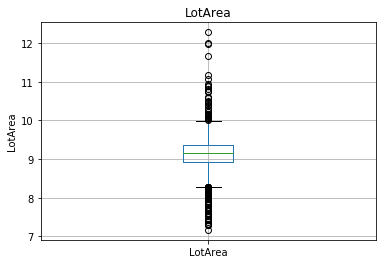

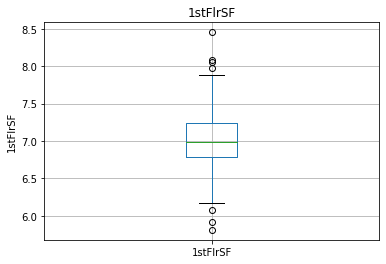

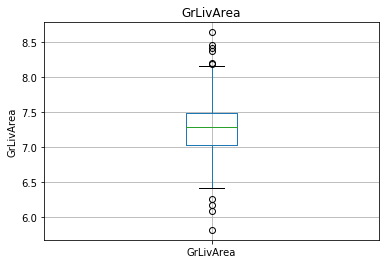

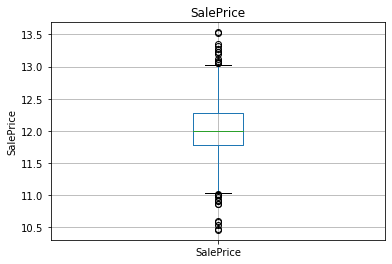

In [275]:
for i in cont_feature:
    df1 = df.copy()
    if 0 in df[i].unique():
        pass
    else:
        df1[i] = np.log(df[i])
        df1.boxplot(i)
        plt.ylabel(i)
        plt.title(i)
        plt.show()

# Categorical

In [276]:
cat_feature = [i for i in df.columns if df[i].dtypes == 'O' ]
cat_feature

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [277]:
df[cat_feature].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [278]:
for i in cat_feature:
    print('The Feauture is  {} and number of unique values is {}'.format(i, len(df[i].unique())))

The Feauture is  MSZoning and number of unique values is 5
The Feauture is  Street and number of unique values is 2
The Feauture is  Alley and number of unique values is 3
The Feauture is  LotShape and number of unique values is 4
The Feauture is  LandContour and number of unique values is 4
The Feauture is  Utilities and number of unique values is 2
The Feauture is  LotConfig and number of unique values is 5
The Feauture is  LandSlope and number of unique values is 3
The Feauture is  Neighborhood and number of unique values is 25
The Feauture is  Condition1 and number of unique values is 9
The Feauture is  Condition2 and number of unique values is 8
The Feauture is  BldgType and number of unique values is 5
The Feauture is  HouseStyle and number of unique values is 8
The Feauture is  RoofStyle and number of unique values is 6
The Feauture is  RoofMatl and number of unique values is 8
The Feauture is  Exterior1st and number of unique values is 15
The Feauture is  Exterior2nd and number

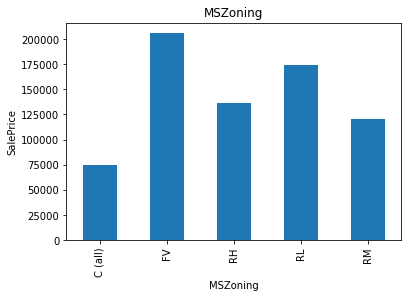

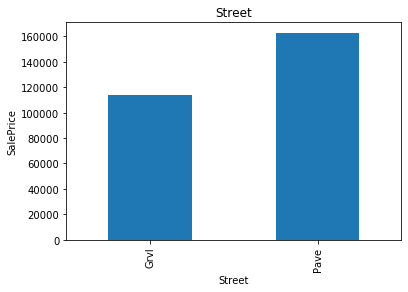

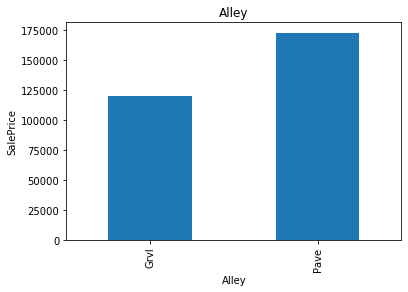

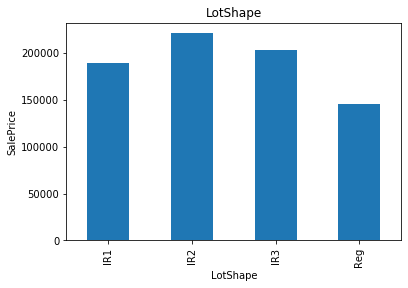

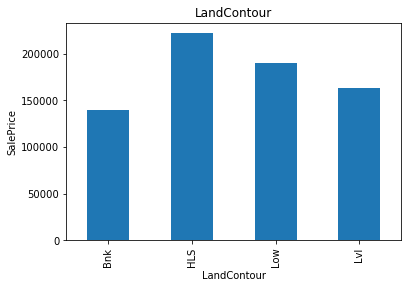

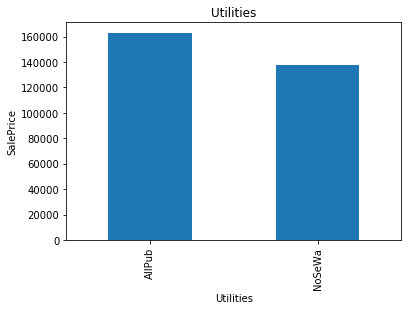

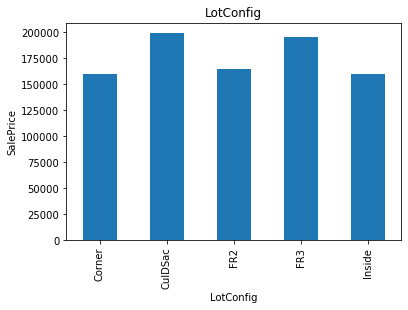

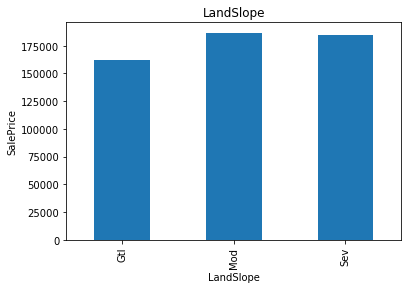

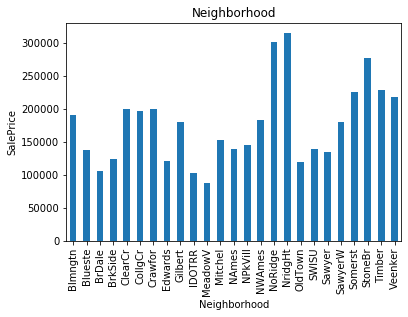

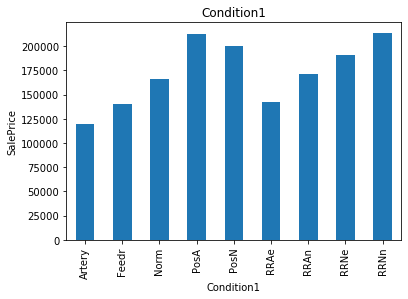

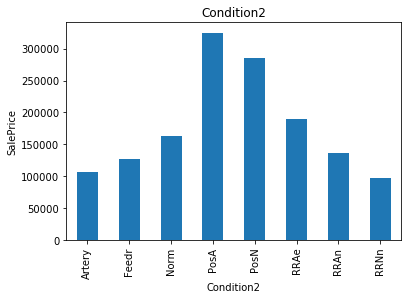

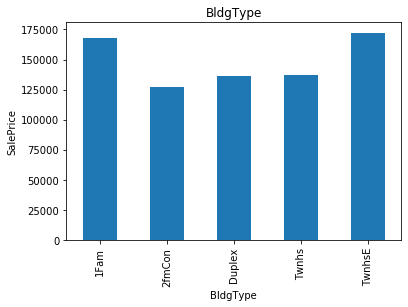

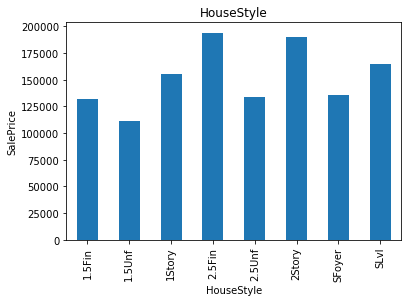

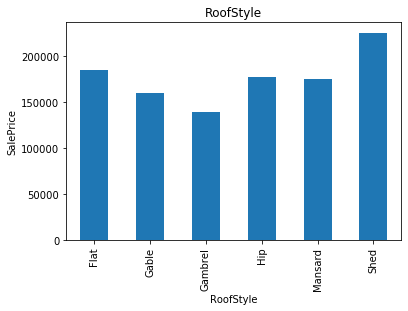

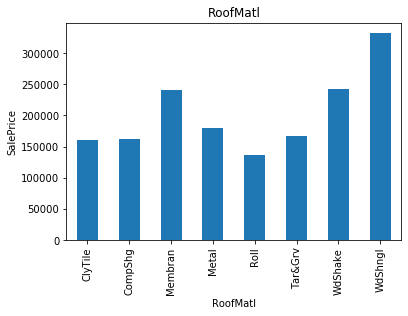

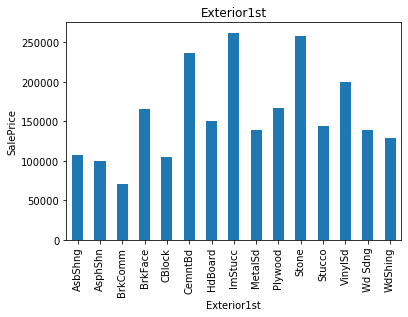

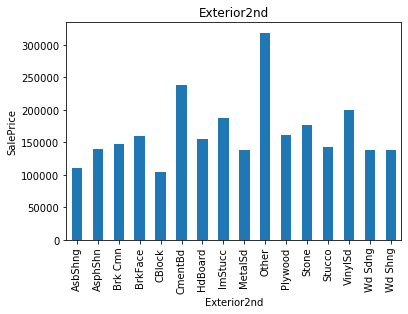

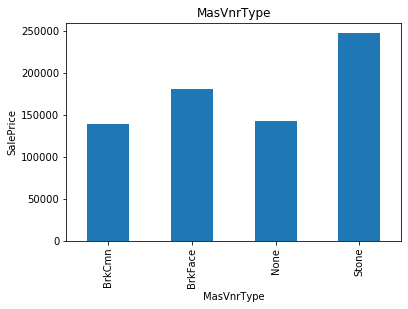

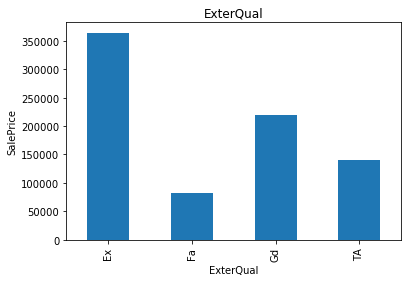

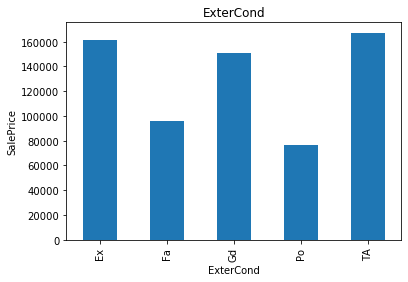

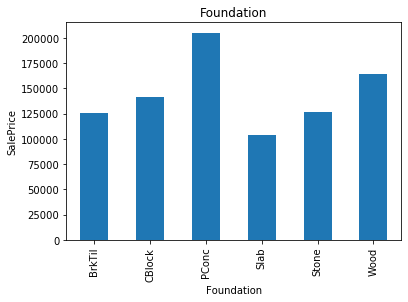

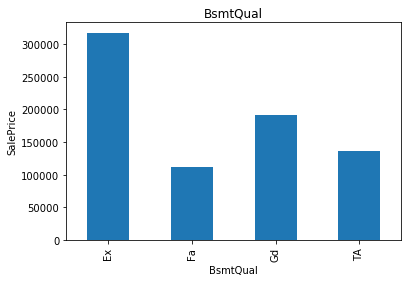

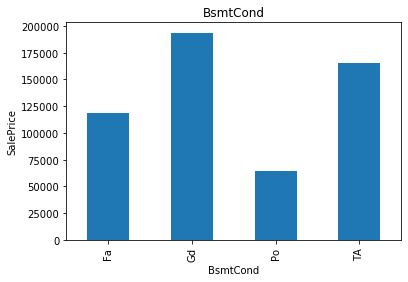

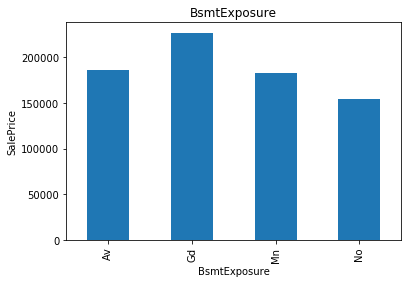

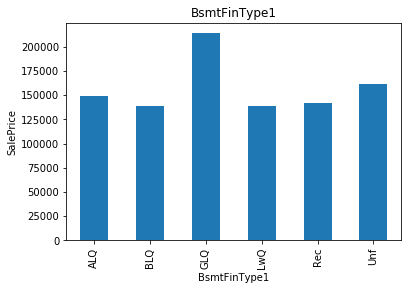

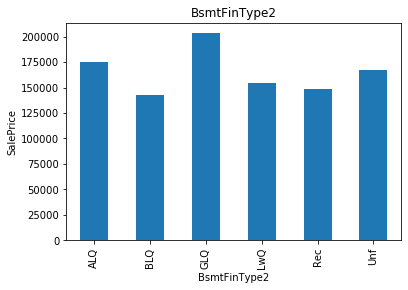

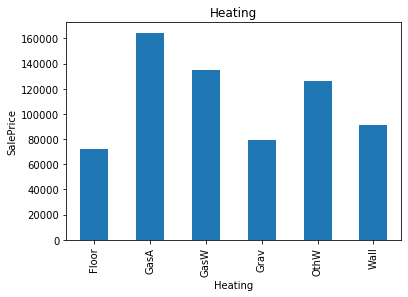

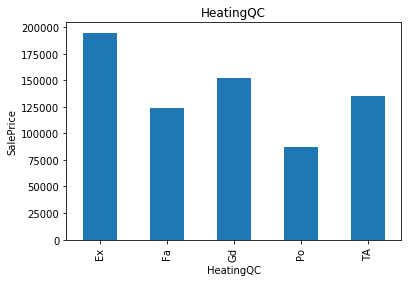

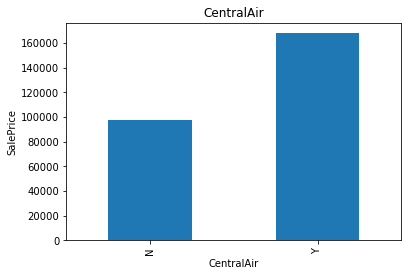

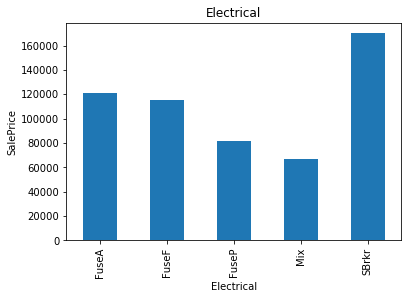

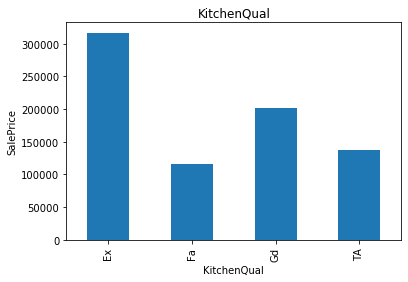

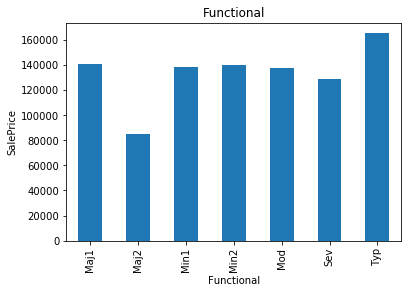

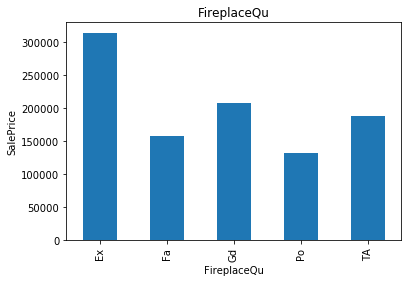

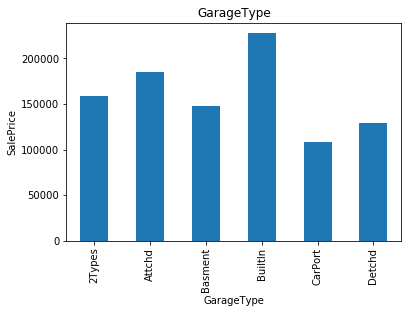

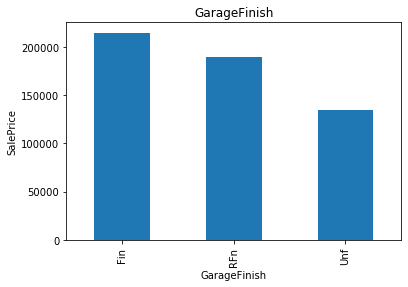

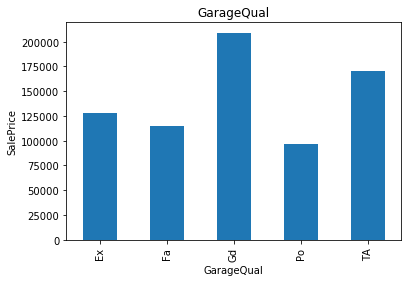

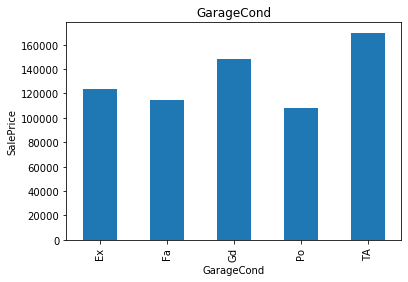

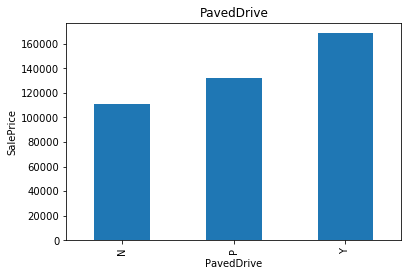

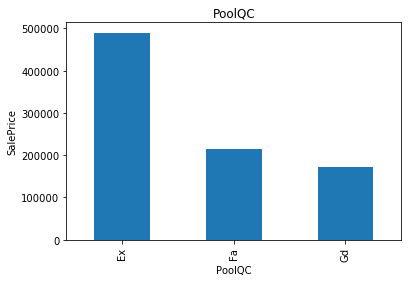

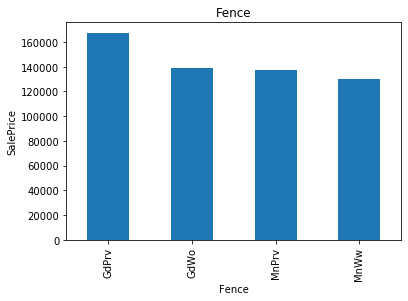

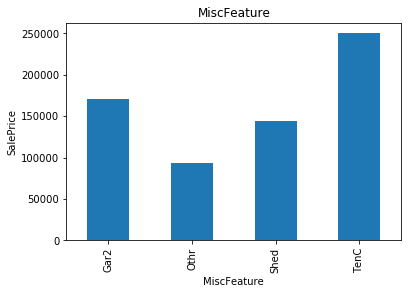

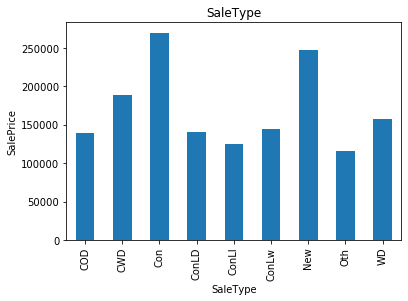

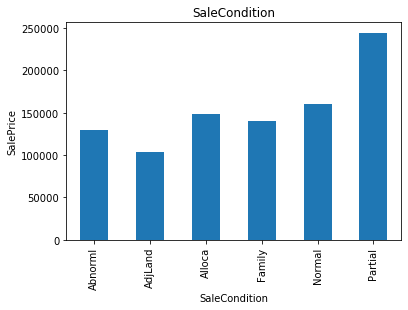

In [279]:
# Find out relation with the dependent variable
for i in cat_feature:
    df.groupby(i)['SalePrice'].median().plot.bar()
    plt.xlabel(i)
    plt.ylabel('SalePrice')
    plt.title(i)
    plt.show()

# Feature Engineering

# Missing values

In [422]:
cat_missing_col = [i for i in df.columns if df[i].isnull().sum()>1 and df[i].dtypes=='O']

for i in cat_missing_col:
    print('{}: {}% Missing values'.format(i, round(df[i].isnull().mean(),3)))

Alley: 0.938% Missing values
MasVnrType: 0.005% Missing values
BsmtQual: 0.025% Missing values
BsmtCond: 0.025% Missing values
BsmtExposure: 0.026% Missing values
BsmtFinType1: 0.025% Missing values
BsmtFinType2: 0.026% Missing values
FireplaceQu: 0.473% Missing values
GarageType: 0.055% Missing values
GarageFinish: 0.055% Missing values
GarageQual: 0.055% Missing values
GarageCond: 0.055% Missing values
PoolQC: 0.995% Missing values
Fence: 0.808% Missing values
MiscFeature: 0.963% Missing values


In [423]:
# Replace missings with new variable
def replace_cat_feauture(df, cat_missing_col):
    df[cat_missing_col] = df[cat_missing_col].fillna('Missing')
    return df

df = replace_cat_feauture(df,cat_missing_col)

In [424]:
df[missing_col].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [425]:
num_missing_col = [i for i in df.columns if df[i].isnull().sum()>1 and df[i].dtypes!='O']

for i in num_missing_col:
    print('{}: {}% Missing values'.format(i, round(df[i].isnull().mean(),3)))

LotFrontage: 0.177% Missing values
MasVnrArea: 0.005% Missing values
GarageYrBlt: 0.055% Missing values


In [426]:
# Replace the numerical missing value
for i in num_missing_col:
    df[i+'_nan'] = np.where(df[i].isnull(),1,0) # If null then label it 1 else 0
    df[i] = df[i].fillna(df[i].median())
    
df[num_missing_col].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [427]:
# Temporal Variable (Date variables)

for i in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    df[i] = df['YrSold'] - df[i]

In [428]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_nan,MasVnrArea_nan,GarageYrBlt_nan
0,1,60,RL,65.0,8450,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Missing,Attchd,5.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Missing,Missing,Missing,0,2,2008,WD,Normal,208500,0,0,0
1,2,20,RL,80.0,9600,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,31.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Missing,Missing,Missing,0,5,2007,WD,Normal,181500,0,0,0
2,3,60,RL,68.0,11250,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,7.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Missing,Missing,Missing,0,9,2008,WD,Normal,223500,0,0,0
3,4,70,RL,60.0,9550,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,8.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Missing,Missing,Missing,0,2,2006,WD,Abnorml,140000,0,0,0
4,5,60,RL,84.0,14260,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,8.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Missing,Missing,Missing,0,12,2008,WD,Normal,250000,0,0,0


# Log Normal Operation 

> Since the numerical variables are skewed, we will perform log normal distribution

In [429]:
num_features = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']

for i in num_features:
    df[i] = np.log(df[i])

In [430]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_nan,MasVnrArea_nan,GarageYrBlt_nan
0,1,60,RL,4.174387,9.041922,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,6.752270,854,0,7.444249,1,0,2,1,3,1,Gd,8,Typ,0,Missing,Attchd,5.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Missing,Missing,Missing,0,2,2008,WD,Normal,12.247694,0,0,0
1,2,20,RL,4.382027,9.169518,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,7.140453,0,0,7.140453,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,31.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Missing,Missing,Missing,0,5,2007,WD,Normal,12.109011,0,0,0
2,3,60,RL,4.219508,9.328123,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,6.824374,866,0,7.487734,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,7.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Missing,Missing,Missing,0,9,2008,WD,Normal,12.317167,0,0,0
3,4,70,RL,4.094345,9.164296,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,6.867974,756,0,7.448334,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,8.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Missing,Missing,Missing,0,2,2006,WD,Abnorml,11.849398,0,0,0
4,5,60,RL,4.430817,9.565214,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,7.043160,1053,0,7.695303,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,8.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Missing,Missing,Missing,0,12,2008,WD,Normal,12.429216,0,0,0


# Handling Rare categorical Feature

> We will remove categorical variables that are present less than 1% of the observation

In [431]:
cat_feature = [i for i in df.columns if df[i].dtypes=='O']
cat_feature

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [432]:
for i in cat_feature:
    temp =  df[i].value_counts()/len(df)
    temp_df = temp[temp>0.01].index
    df[i] = np.where(df[i].isin(temp_df), df[i], 'Rare_var')

In [433]:
df.head(35)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_nan,MasVnrArea_nan,GarageYrBlt_nan
0,1,60,RL,4.174387,9.041922,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,6.752270,854,0,7.444249,1,0,2,1,3,1,Gd,8,Typ,0,Missing,Attchd,5.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Missing,Missing,Missing,0,2,2008,WD,Normal,12.247694,0,0,0
1,2,20,RL,4.382027,9.169518,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Rare_var,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,7.140453,0,0,7.140453,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,31.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Missing,Missing,Missing,0,5,2007,WD,Normal,12.109011,0,0,0
2,3,60,RL,4.219508,9.328123,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,6.824374,866,0,7.487734,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,7.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Missing,Missing,Missing,0,9,2008,WD,Normal,12.317167,0,0,0
3,4,70,RL,4.094345,9.164296,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,6.867974,756,0,7.448334,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,8.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Missing,Missing,Missing,0,2,2006,WD,Abnorml,11.849398,0,0,0
4,5,60,RL,4.430817,9.565214,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,7.043160,1053,0,7.695303,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,8.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Missing,Missing,Missing,0,12,2008,WD,Normal,12.429216,0,0,0
5,6,50,RL,4.442651,9.554993,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,16,14,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Rare_var,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,6.679599,566,0,7.216709,1,0,1,1,1,1,TA,5,Typ,0,Missing,Attchd,16.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,Missing,MnPrv,Shed,700,10,2009,WD,Normal,11.870600,0,0,0
6,7,20,RL,4.317488,9.218705,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,3,2,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,7.434848,0,0,7.434848,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,3.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,Missing,Missing,Missing,0,8,2007,WD,Normal,12.634603,0,0,0
7,8,60,RL,4.234107,9.247829,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,36,36,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,7.009409,983,0,7.644919,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,36.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,Missing,Missing,Shed,350,11,2009,WD,Normal,12.206073,1,0,0
8,9,50,RM,3.931826,8.719317,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,77,58,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF

In [434]:
for i in cat_feature:
    labels_ordered=df.groupby([i])['SalePrice'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered)}    # enumerate is a iterable object
    df[i]=df[i].map(labels_ordered)

In [435]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_nan,MasVnrArea_nan,GarageYrBlt_nan
0,1,60,3,4.174387,9.041922,1,2,0,1,1,0,0,14,2,1,3,5,7,5,5,5,0,0,10,10,2,196.0,2,3,4,3,3,1,6,706,5,0,150,856,2,4,1,3,6.752270,854,0,7.444249,1,0,2,1,3,1,2,8,4,0,1,4,5.0,2,2,548,2,3,2,0,61,0,0,0,0,0,4,2,0,2,2008,2,3,12.247694,0,0,0
1,2,20,3,4.382027,9.169518,1,2,0,1,1,2,0,11,1,1,3,3,6,8,31,31,0,0,4,3,1,0.0,1,3,2,3,3,4,4,978,5,0,284,1262,2,4,1,3,7.140453,0,0,7.140453,0,1,2,0,3,1,1,6,4,1,3,4,31.0,2,2,460,2,3,2,298,0,0,0,0,0,0,4,2,0,5,2007,2,3,12.109011,0,0,0
2,3,60,3,4.219508,9.328123,1,2,1,1,1,0,0,14,2,1,3,5,7,5,7,6,0,0,10,10,2,162.0,2,3,4,3,3,2,6,486,5,0,434,920,2,4,1,3,6.824374,866,0,7.487734,1,0,2,1,3,1,2,6,4,1,3,4,7.0,2,2,608,2,3,2,0,42,0,0,0,0,0,4,2,0,9,2008,2,3,12.317167,0,0,0
3,4,70,3,4.094345,9.164296,1,2,1,1,1,1,0,16,2,1,3,5,7,5,91,36,0,0,2,4,1,0.0,1,3,1,2,4,1,4,216,5,0,540,756,2,3,1,3,6.867974,756,0,7.448334,1,0,1,0,3,1,2,7,4,1,4,2,8.0,1,3,642,2,3,2,0,35,272,0,0,0,0,4,2,0,2,2006,2,0,11.849398,0,0,0
4,5,60,3,4.430817,9.565214,1,2,1,1,1,2,0,22,2,1,3,5,8,5,8,8,0,0,10,10,2,350.0,2,3,4,3,3,3,6,655,5,0,490,1145,2,4,1,3,7.043160,1053,0,7.695303,1,0,2,1,4,1,2,9,4,1,3,4,8.0,2,3,836,2,3,2,192,84,0,0,0,0,0,4,2,0,12,2008,2,3,12.429216,0,0,0


# Feature scaling

In [436]:
feature_scale = df.columns.difference(['Id', 'SalePrice'])

scaler = MinMaxScaler()
scaler.fit(df[feature_scale])

MinMaxScaler()

In [437]:
scaler.transform(df[feature_scale])

array([[0.35615475, 0.41355932, 0.        , ..., 0.03676471, 0.09836066,
        0.5       ],
       [0.50305602, 0.        , 0.        , ..., 0.22794118, 0.52459016,
        0.25      ],
       [0.38344104, 0.41937046, 0.        , ..., 0.05147059, 0.1147541 ,
        0.5       ],
       ...,
       [0.4801886 , 0.55786925, 0.        , ..., 0.50735294, 0.08196721,
        1.        ],
       [0.44341859, 0.        , 0.        , ..., 0.44117647, 0.24590164,
        1.        ],
       [0.50125252, 0.        , 0.        , ..., 0.31617647, 0.72131148,
        0.5       ]])

In [444]:
# transform the train and test set, and add on the Id and SalePrice variables
df_final = pd.concat([df[['Id', 'SalePrice']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(df[feature_scale]), columns=feature_scale)],
                    axis=1)

In [445]:
df_final.head()

,Id,SalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GarageYrBlt_nan,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotFrontage_nan,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrArea_nan,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,1,12.247694,0.356155,0.413559,0.0,1.0,0.375,0.75,0.75,0.25,0.125089,0.0,1.000000,0.833333,0.333333,0.0,0.75,0.064212,1.0,0.4,1.0,1.0,0.000000,1.0,0.666667,1.0,1.0,1.0,0.2,0.000000,1.00,0.666667,1.0,0.386460,0.50,1.0,0.666667,0.666667,0.8,0.046729,0.0,0.577712,0.5,1.0,1.00,1.0,0.333333,0.666667,0.333333,0.0,0.366344,0.00,0.418208,0.0,0.000000,0.0,0.235294,0.75,0.12250,0.0,0.50,1.0,0.0,0.090909,0.636364,0.111517,0.500,0.666667,1.0,0.0,0.0,0.0,0.0,0.75,0.666667,0.0,1.0,0.500000,0.140098,1.0,0.000000,0.036765,0.098361,0.50
1,2,12.109011,0.503056,0.000000,0.0,1.0,0.375,0.75,0.75,1.00,0.173281,0.0,0.666667,0.833333,0.000000,0.5,0.75,0.121575,1.0,0.2,1.0,1.0,0.000000,1.0,0.333333,0.4,0.3,1.0,0.6,0.333333,0.50,0.666667,1.0,0.324401,0.50,1.0,0.666667,0.666667,0.8,0.289720,0.0,0.470245,0.0,1.0,1.00,0.6,0.333333,0.333333,0.333333,0.0,0.391317,0.50,0.495064,0.0,0.000000,0.0,0.000000,0.75,0.00000,0.0,0.25,1.0,0.0,0.363636,0.500000,0.000000,0.875,0.555556,1.0,0.0,0.0,0.0,0.0,0.75,0.666667,0.0,1.0,0.333333,0.206547,1.0,0.347725,0.227941,0.524590,0.25
2,3,12.317167,0.383441,0.419370,0.0,1.0,0.375,0.75,0.75,0.50,0.086109,0.0,1.000000,0.833333,0.333333,0.0,0.75,0.185788,1.0,0.4,1.0,1.0,0.000000,1.0,0.666667,1.0,1.0,1.0,0.6,0.333333,1.00,0.666667,1.0,0.428773,0.50,1.0,0.666667,0.666667,0.8,0.065421,0.0,0.593095,0.5,1.0,1.00,1.0,0.333333,0.666667,0.333333,0.0,0.422359,0.00,0.434909,0.0,0.333333,0.0,0.235294,0.75,0.10125,0.0,0.50,1.0,0.0,0.727273,0.636364,0.076782,0.500,0.666667,1.0,0.0,0.0,0.0,0.0,0.75,0.666667,0.0,1.0,0.333333,0.150573,1.0,0.000000,0.051471,0.114754,0.50
3,4,11.849398,0.399941,0.366102,0.0,1.0,0.375,0.75,1.00,0.25,0.038271,0.0,0.666667,0.833333,0.333333,0.0,0.50,0.231164,1.0,0.4,1.0,1.0,0.492754,1.0,0.333333,0.2,0.4,1.0,0.8,0.333333,0.25,0.333333,1.0,0.452750,0.75,1.0,0.333333,0.666667,0.4,0.074766,0.0,0.579157,0.0,1.0,0.75,1.0,0.333333,0.666667,0.333333,0.0,0.390295,0.25,0.388581,0.0,0.333333,0.0,0.294118,0.75,0.00000,0.0,0.25,1.0,0.0,0.090909,0.727273,0.063985,0.500,0.666667,1.0,0.0,0.0,0.0,0.0,0.00,0.666667,0.0,1.0,0.416667,0.123732,1.0,0.000000,0.669118,0.606557,0.00
4,5,12.429216,0.466237,0.509927,0.0,1.0,0.500,0.75,0.75,0.75,0.116052,0.0,1.000000,0.833333,0.333333,0.0,0.75,0.209760,1.0,0.4,1.0,1.0,0.000000,1.0,0.666667,1.0,1.0,1.0,0.6,0.333333,1.00,0.666667,1.0,0.589563,0.75,1.0,0.666667,0.666667,0.8,0.074766,0.0,0.666523,0.5,1.0,1.00,1.0,0.333333,0.666667,0.333333,0.0,0.468761,0.50,0.513123,0.0,0.333333,0.0,0.235294,0.75,0.21875,0.0,0.50,1.0,0.0,1.000000,1.000000,0.153565,0.500,0.777778,1.0,0.0,0.0,0.0,0.0,0.75,0.666667,0.0,1.0,0.583333,0.187398,1.0,0.224037,0.058824,0.147541,0.50


In [446]:
df_final.shape

(1460, 84)

# Feature selection

In [447]:
x_train = df_final.drop(['Id', 'SalePrice'], axis = 1)
y_train = df_final['SalePrice']

In [448]:
# Apply feature selection, select the suitable alpha value, the bigger the alpha value the less feature will be selectes,
# then use selectfrom model, which will select the features with coefficient are non zero

feature_sel_model = SelectFromModel(Lasso(alpha = 0.005, random_state = 0))
feature_sel_model.fit(x_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [449]:
selected_feature = x_train.columns[feature_sel_model.get_support()]

print('The Total Features: ', len(x_train.columns))
print('The Selected Features: ', len(selected_feature))
print('Features with coefficients shrank to zero : {}'.format(np.sum(feature_sel_model.estimator_.coef_==0)))

The Total Features:  82
The Selected Features:  21
Features with coefficients shrank to zero : 61


In [450]:
selected_feature

Index(['1stFlrSF', 'BsmtExposure', 'BsmtFullBath', 'BsmtQual', 'CentralAir',
       'FireplaceQu', 'Fireplaces', 'GarageCars', 'GarageFinish', 'GarageType',
       'GrLivArea', 'HeatingQC', 'KitchenQual', 'MSSubClass', 'MSZoning',
       'Neighborhood', 'OverallQual', 'PavedDrive', 'RoofStyle',
       'SaleCondition', 'YearRemodAdd'],
      dtype='object')

In [451]:
x_train = x_train[selected_feature]
x_train.head()

,1stFlrSF,BsmtExposure,BsmtFullBath,BsmtQual,CentralAir,FireplaceQu,Fireplaces,GarageCars,GarageFinish,GarageType,GrLivArea,HeatingQC,KitchenQual,MSSubClass,MSZoning,Neighborhood,OverallQual,PavedDrive,RoofStyle,SaleCondition,YearRemodAdd
0,0.356155,0.25,0.333333,0.75,1.0,0.2,0.000000,0.50,0.666667,0.8,0.577712,1.00,0.666667,0.235294,0.75,0.636364,0.666667,1.0,0.0,0.75,0.098361
1,0.503056,1.00,0.000000,0.75,1.0,0.6,0.333333,0.50,0.666667,0.8,0.470245,1.00,0.333333,0.000000,0.75,0.500000,0.555556,1.0,0.0,0.75,0.524590
2,0.383441,0.50,0.333333,0.75,1.0,0.6,0.333333,0.50,0.666667,0.8,0.593095,1.00,0.666667,0.235294,0.75,0.636364,0.666667,1.0,0.0,0.75,0.114754
3,0.399941,0.25,0.333333,0.50,1.0,0.8,0.333333,0.75,0.333333,0.4,0.579157,0.75,0.666667,0.294118,0.75,0.727273,0.666667,1.0,0.0,0.00,0.606557
4,0.466237,0.75,0.333333,0.75,1.0,0.6,0.333333,0.75,0.666667,0.8,0.666523,1.00,0.666667,0.235294,0.75,1.000000,0.777778,1.0,0.0,0.75,0.147541


In [452]:
from xgboost import XGBRFRegressor, XGBRegressor

In [453]:
cls = XGBRegressor()
cls.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [454]:
result_train = pd.DataFrame()

result_train['Predicted'] = cls.predict(x_train)
result_train['Actual'] = y_train


# Accuracy

print('Train Accuracy', r2_score(y_train, result_train.Predicted))


print('Train Error', np.sqrt(mean_squared_log_error(y_train,  result_train.Predicted)))


Train Accuracy 0.9965690050035528
Train Error 0.0018020036777390794


# Random search cv

In [455]:
param_grid = {'n_estimators': [100,500,900,1500],
             'max_depth': [2,3,5,10,15],
             'booster': ['gbtree', 'gblinear'],
             'learning_rate': [0.05,0.1,0.15,0.20],
             'min_child_weight': [1,2,3,4]}

In [456]:
cv = RandomizedSearchCV(estimator = XGBRegressor(), param_distributions = param_grid, cv = 5, n_iter = 50, scoring = 'neg_mean_absolute_error', n_jobs = 4,
                       verbose = True, return_train_score= True, random_state = 42)
cv.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [457]:
result_train = pd.DataFrame()

result_train['Predicted'] = cls.predict(x_train)
result_train['Actual'] = y_train


# Accuracy

print('Train Accuracy', r2_score(y_train, result_train.Predicted))


print('Train Error', np.sqrt(mean_squared_log_error(y_train,  result_train.Predicted)))

Train Accuracy 0.9965690050035528
Train Error 0.0018020036777390794


# Predict for test data

In [459]:
df = pd.read_csv('test.csv')



cat_missing_col = [i for i in df.columns if df[i].isnull().sum()>0 and df[i].dtypes=='O']
def replace_cat_feauture(df, cat_missing_col):
    df[cat_missing_col] = df[cat_missing_col].fillna('Missing')
    return df

df = replace_cat_feauture(df,cat_missing_col)

num_missing_col = [i for i in df.columns if df[i].isnull().sum()>0 and df[i].dtypes!='O']
for i in num_missing_col:
    df[i+'_nan'] = np.where(df[i].isnull(),1,0) # If null then label it 1 else 0
    df[i] = df[i].fillna(df[i].median())
    

for i in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    df[i] = df['YrSold'] - df[i]

num_features = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']

for i in num_features:
    df[i] = np.log(df[i])

cat_feature = [i for i in df.columns if df[i].dtypes=='O']
for i in cat_feature:
    temp =  df[i].value_counts()/len(df)
    temp_df = temp[temp>0.01].index
    df[i] = np.where(df[i].isin(temp_df), df[i], 'Rare_var')

for i in cat_feature:
    labels_ordered=df.groupby([i])['LotFrontage'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered)}    # enumerate is a iterable object
    df[i]=df[i].map(labels_ordered)

feature_scale = df.columns.difference(['Id'])

scaler = MinMaxScaler()
scaler.fit(df[feature_scale])

df_final = pd.concat([df[['Id']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(df[feature_scale]), columns=feature_scale)],
                    axis=1)

dff = df_final[['1stFlrSF', 'BsmtExposure', 'BsmtFullBath', 'BsmtQual', 'CentralAir',
       'FireplaceQu', 'Fireplaces', 'GarageCars', 'GarageFinish', 'GarageType',
       'GrLivArea', 'HeatingQC', 'KitchenQual', 'MSSubClass', 'MSZoning',
       'Neighborhood', 'OverallQual', 'PavedDrive', 'RoofStyle',
       'SaleCondition', 'YearRemodAdd']]

In [460]:
submission = pd.DataFrame({'Id' : df_final['Id'], 'SalePrice': np.exp(cls.predict(dff))})

In [461]:
submission.to_csv('submission.csv', index = False)